<a href="https://colab.research.google.com/github/hyuntaedo/Data_Analysis/blob/main/Audio_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##오디오 처리(Audio Processing)
 - 소리는 진동으로 인한 공기의 압축으로 생성
 - 압축이 얼마나 됬느냐에 따라 진동하며, 공간이나 매질을 전파해가는 현상인 Wave(파동)로 표현
 - 파동에서 얻을수 있는 정보
   - 위상(Phase; Degress of displacement)
   - 진폭(Amplitude; Intensity)
   - 주파수(Frequency)
   ![](https://miro.medium.com/max/700/0*QFVha2lCgyhKjhuO.gif)

## 오디오 라이브러리
 - librosa는 각종 음성 처리에 유용한 라이브러리
 - colab환경에서 torchaudio는 별도 설치가 필요

In [ ]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 4.9MB/s 
     |████████████████████████████████| 831.4MB 17kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.9.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.9.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa
import librosa.display
import torchaudio
import torch
import IPython.display as ipd

## 오디오 데이터
 - pytorch의 torchaudio를 사용해 내장 데이터 셋을 가져옴
 - 데이터가 크기때문에 시간이 많이 필요

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH('./',url='train-clean-100',download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH('./',url='test-clean',download=True)

### 불러온 데이터 확인
 - 첫번째 줄에는 소리 데이터 확인가능
 - 두번째 줄에선 해당 데이터의 sampling rate 확인 가능

In [ ]:
test_dataset[1]

(tensor([[ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]]),
 16000,
 'STUFF IT INTO YOU HIS BELLY COUNSELLED HIM',
 1089,
 134686,
 1)

 - 불러온 데이터의 형상을 확인
 - 데이터 길이만으로는 음성이 몇초에 해당하는지를 알 수 없음

In [ ]:
test_dataset[3][0].shape

torch.Size([1, 42880])

## 샘플링(Sampling)

### Sampling

* 음성을 처리하기 위해 아날로그 정보를 잘게 쪼개 이산적인 디지털 정보로 표현해야 함
* 이때 무한히 쪼개서 저장할 수는 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값을 사용, 이를 샘플링이라 함
* 주로 사용할 때 시간을 기준으로 아날로그 정보를 쪼개는 Time Domain 방식을 사용

* Sampling rate
  * sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지를 결정
  * 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남
* Sampling theorem
  * sampling rate가 최대 frequency보다 2배 커져야 함을 의미
  * 일반적으로 sampling은 인간의 청각 영역에 맞게 형성
    - Audio CD : 44.1 kHz(44100 sample/second)
    - Speech communication : 8 kHz(8000 sample/second)



*   음성의 duration은 데이터의 길이와 sampling rate를 나누어 확인 가능

In [ ]:
audio_data = test_dataset[1][0][0]
sr = test_dataset[1][1]

print(audio_data,sr)
print('length',len(audio_data))
print('duration',len(audio_data)/sr)
ipd.Audio(audio_data,rate=sr)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length 52400
duration 3.275


### Resampling

* Resampling은 sampling data의 sampling rate를 조정해 다시 sampling하는 것
* 이때 일반적으로 보간(interpolation)을 할때는 low-pass filter를 사용
* `librosa.resample`을 사용하면 편리하게 resampling 가능
* 현재 데이터는 `torch tensor`, `librosa`는 `numpy` 배열을 받아들이기 때문에 변환 필요
* sampling rate를 절반으로 줄여, 길이도 절반으로 준 것을 확인할 수 있음


In [ ]:
audio_numpy = audio_data.numpy()
y_8k = librosa.resample(audio_numpy,sr,8000)

print(len(audio_data),len(y_8k))
ipd.Audio(y_8k,rate=8000)

52400 26200


In [ ]:
audio_numpy = audio_data.numpy()
y_8k = librosa.resample(audio_numpy,sr,4000)

print(len(audio_data),len(y_8k))
ipd.Audio(y_8k,rate=4000)

52400 13100


### Normalization & Quantization

*   데이터간 음량이 제각각인 경우 normalization을 하여 amplitude를 [-1, 1] 범위로 조정
*   여기서는 가장 간단한 방법인 데이터의 최대값으로 나눠주는 방법을 사용

In [ ]:
audio_numpy = audio_data.numpy()
normed_wav = audio_numpy / max(np.abs(audio_numpy))
ipd.Audio(normed_wav,rate=sr)

In [ ]:
bit = 8
max_value = 2 ** (bit-1)

quantized_8_wave = normed_wav * max_value
quantized_8_wave = np.round(quantized_8_wave).astype(int)
quantized_8_wave = np.clip(quantized_8_wave, -max_value, max_value -1)
ipd.Audio(quantized_8_wave,rate=sr)

### Mu-Law Encoding

* 사람의 귀는 작은소리의 차이는 잘잡아내는데 반해 소리가 커질수록 그 차이를 잘 느끼지 못함
* 이러한 특성을 wave값을 표현하는데 반영해 작은 값에는 높은 분별력을, 큰 값끼리는 낮은 분별력을 갖도록 함



In [ ]:
def mu_law(x,mu=255):
    return np.sign(x) * np.log(1 + mu + np.abs(x)) / np.log(1+mu)

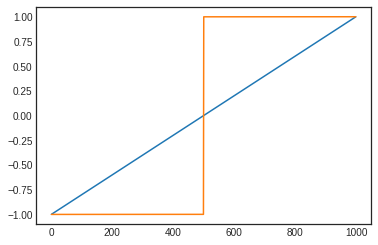

In [ ]:
x = np.linspace(-1,1,1000)
x_mu = mu_law(x)

plt.figure(figsize=[6,4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [ ]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw,rate=sr)

# 오디오 표현(Audio Representation)

* Sampling된 discrete한 데이터를 표현
  + 시간의 흐름에 따라, 공기의 파동의 크기로 보는 Time-Domain Representation 방법
  + 시간에 따라서 frequency의 변화를 보는 Time-Frequency Representation

## Waveform - Time-Domain Representation

* Waveform은 오디오의 자연적인 표현
* 시간이 x축으로 그리고 amplitude가 y축으로 표현

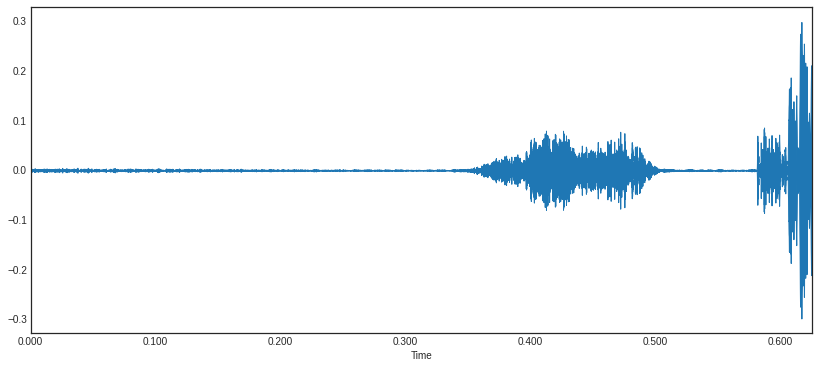

In [ ]:
audio_numpy = audio_data.numpy()
fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(audio_numpy[0:10000], sr=sr)

## 정현파(Sinusoid) - Time-Frequency Representation

![](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png)

* 모든 신호는 주파수(frequency)와 크기(magnitude), 위상(phase)이 다른 정현파(sinusolida signal)의 조합으로 나타낼 수 있음
* 푸리에 변환은 조합된 정현파의 합(하모니) 신호에서 그 신호를 구성하는 정현파들을 각각 분리해내는 방법

In [ ]:
def Sinusoid(A,f,phi,fs,t):
    t = np.arange(0,t,1.0/fs)
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [ ]:
A = 0.9
f = 340
phi = np.pi/2
fs = 22050
t = 1

In [ ]:
sin = Sinusoid(A,f,phi,fs,t)

In [ ]:
A = 0.9
f = 260
phi = np.pi/2
fs = 22050
t = 1

In [ ]:
sin2 = Sinusoid(A,f,phi,fs,t)

In [ ]:
complex_wave = sin + sin2

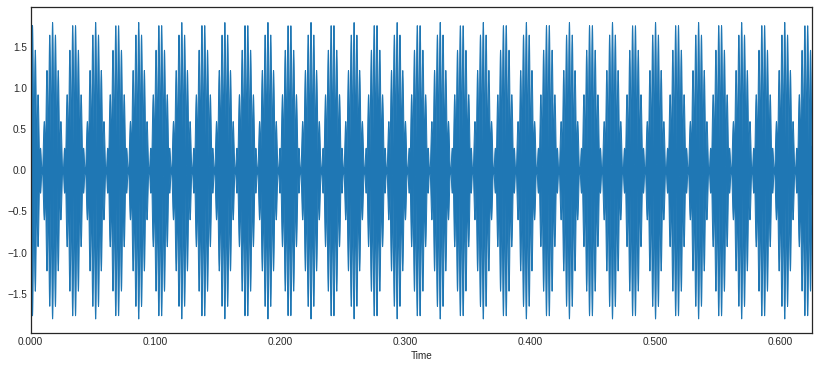

In [ ]:
fig = plt.figure(figsize=(14,6))
librosa.display.waveplot(complex_wave[0:10000],sr=sr)

In [ ]:
ipd.Audio(sin+sin/2 + sin/4, rate=fs)

In [ ]:
ipd.Audio(sin2+sin2/2 + sin2/4, rate=fs)

In [ ]:
def generate_sinusoid_scale(pitches=[69],duration=0.5,fs=22050,ampplitude_max=0.5):
    N = int(duration *fs)
    t = np.arange(N) / fs
    x = []
    for p in pitches:
        omega = 2 ** ((p-69)/12) * 440
        x = np.append(x,np.sin(2 *np.pi * omega * t))
    x = ampplitude_max * x / np.max(x)
    return x

In [ ]:
duration = 1
fs = 22050
pitches = [36,48,60,72,84,96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, fs=fs)
print('pitch class C = {..., C1, C2, C3, C4, C5, C6}')
ipd.display(ipd.Audio(data=x,rate=fs)) 

pitch class C = {..., C1, C2, C3, C4, C5, C6}
